# Data cleaning and preprocessing

In [1]:
### Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew

In [2]:
### Following dfs are used for content-based algorithm

movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")
keywords = pd.read_csv("keywords.csv")

In [3]:
### Examine the datasets

print("Movies dataset:")
# print(movies.head())
print(movies.info())

print("\nCredits dataset:")
# print(credits.head())
print(credits.info())

print("\nKeywords dataset:")
# print(keywords.head())
print(keywords.info())

Movies dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  statu

In [4]:
### Handle the missing values
## Only released movies are considered (not rumored, post-production)

movies.fillna("", inplace=True)
movies = movies[movies["status"] == "Released"]
movies = movies.drop(columns=["homepage", "tagline", "status"])


credits.fillna("", inplace=True)
keywords.fillna("", inplace=True)

# Dataset merging & final cleanup

In [5]:
### Function to get names from dicts of ids and names (applies to many columns in our data)
    # change 'name' to 'id' if 'id' is wanted instead

def extract_names(column_data):
    column_data = ast.literal_eval(column_data)
    names = [data['name'] for data in column_data]
    return names

In [6]:
### Function to get director from the crew members

def get_director(crew_data):
    crew_data = ast.literal_eval(crew_data)
    for crew_member in crew_data:
        if crew_member['job'] == 'Director':
            return crew_member['name']
    return np.nan

In [7]:
### Prepares content_based_df
### Completes the following:
    # merges movies, credits, and keywords
    # cleans columns to get desired results by renaming columns and using extract_names function

content_based_df = movies.merge(credits, left_on="id", right_on="movie_id", suffixes=("_movies", "_credits"))
content_based_df.drop(columns=["title_credits", "movie_id"], inplace=True)

content_based_df = content_based_df.merge(keywords, on="id", suffixes=("", "_keywords"))
content_based_df.drop(columns=["keywords"], inplace=True)
content_based_df.rename(columns={"keywords_keywords": "keywords"}, inplace=True)

# Set manually
columns_to_clean = [
    'genres', 'production_companies', 'production_countries',
    'spoken_languages', 'cast', 'keywords'
]

for column in columns_to_clean:
    content_based_df[column] = content_based_df[column].apply(extract_names)
    

content_based_df['director'] = content_based_df['crew'].apply(get_director)
content_based_df.dropna(subset=['director'], inplace=True)

content_based_df['release_date'] = pd.to_datetime(content_based_df['release_date'])
content_based_df = content_based_df.drop(columns=["crew"])
content_based_df.set_index('id', inplace=True)
content_based_df = content_based_df.loc[~content_based_df.index.duplicated(keep='first')]

# Produces df with following columns (all 100% ready for next steps):
# ['budget', 'genres', 'id', 'original_language', 'original_title',
#       'popularity', 'production_companies', 'production_countries',
#       'release_date', 'revenue', 'runtime', 'spoken_languages',
#       'title_movies', 'vote_average', 'vote_count', 'cast', 'crew',
#       'keywords']

In [8]:
(content_based_df.head())

,budget,genres,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title_movies,vote_average,vote_count,cast,keywords,director
id,,,,,,,,,,,,,,,,,,
19995,237000000,"[Action, Adventure, Fantasy, Science Fiction]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Avatar,7.2,11800,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[culture clash, future, space war, space colon...",James Cameron
285,300000000,"[Adventure, Fantasy, Action]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961000000,169.0,[English],Pirates of the Caribbean: At World's End,6.9,4500,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[ocean, drug abuse, exotic island, east india ...",Gore Verbinski
206647,245000000,"[Action, Adventure, Crime]",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Spectre,6.3,4466,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[spy, based on novel, secret agent, sequel, mi...",Sam Mendes
49026,250000000,"[Action, Crime, Drama, Thriller]",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012-07-16,1084939099,165.0,[English],The Dark Knight Rises,7.6,9106,"[Christian Bale, Michael Caine, Gary Oldman, A...","[dc comics, crime fighter, terrorist, secret i...",Christopher Nolan
49529,260000000,"[Action, Adventure, Science Fiction]",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,[Walt Disney Pictures],[United States of America],2012-03-07,284139100,132.0,[English],John Carter,6.1,2124,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[based on novel, mars, medallion, space travel...",Andrew Stanton


# Feature Engineering

### Categorical Feature Engineering (categorical variables handled)
***Variables Handled***:
- original_language
- production_companies

In [9]:
### Completes one-hot encoding on categorical variables
# mlb = MultiLabelBinarizer() # Not needed for 'original_language'

# Set up as for loop for chance to expand upon this later if needed
for feature in ['original_language']:
    if feature == 'original_language':
        encoded_features = pd.get_dummies(content_based_df[feature])
    else:
        temp_df = pd.DataFrame(mlb.fit_transform(content_based_df[feature]), columns=mlb.classes_, index=content_based_df.index)
        encoded_features = pd.concat([encoded_features, temp_df], axis=1)

In [10]:
# Convert the column names to a list and print them without truncation
print(', '.join(encoded_features.columns.tolist()))

af, ar, cn, cs, da, de, el, en, es, fa, fr, he, hi, hu, id, is, it, ja, ko, ky, nb, nl, no, pl, ps, pt, ro, ru, sv, te, th, vi, xx, zh


### Numerical Feature Engineering (numerical data)
***Variables Handled***
- budget
- popularity
- release_date
- revenue
- runtime
- vote_average
- vote_count

In [11]:
content_based_df['release_year'] = pd.to_datetime(content_based_df['release_date']).dt.year

# Ensure numerical columns are in the correct data type
numerical_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'release_year']

content_based_df[numerical_cols] = content_based_df[numerical_cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [12]:
### Sees if there are negative/0 values we need to handle

# Prints number of non-positive values in each column
for col in ['budget', 'popularity', 'revenue', 'vote_count', 'release_year', 'vote_average']:
    num_of_non_positive_values = content_based_df[content_based_df[col] <= 0].shape[0]
    print(f'Number of non-positive values in {col}: {num_of_non_positive_values}')

Number of non-positive values in budget: 881
Number of non-positive values in popularity: 0
Number of non-positive values in revenue: 1226
Number of non-positive values in vote_count: 8
Number of non-positive values in release_year: 0
Number of non-positive values in vote_average: 8


In [13]:
# Looks deeper at data regarding 0 bugdet/revenue to decide whether we can remove it or not
zero_budget_revenue = content_based_df[(content_based_df['budget'] <= 1) | (content_based_df['revenue'] <= 1)]

print("Number of rows with zero or near-zero budget or revenue:", len(zero_budget_revenue))
print("Average number of reviews:", zero_budget_revenue['vote_count'].mean())
print("Average rating:", zero_budget_revenue['vote_average'].mean())

# Get a general overview of the datafram
print(zero_budget_revenue.describe())

Number of rows with zero or near-zero budget or revenue: 1372
Average number of reviews: 116.02915451895043
Average rating: 5.925728862973761
             budget   popularity       revenue      runtime  vote_average  \
count  1.372000e+03  1372.000000  1.372000e+03  1372.000000   1372.000000   
mean   5.823004e+06     6.827626  2.630923e+06   101.196064      5.925729   
std    1.390803e+07     7.252500  1.590007e+07    19.756583      1.098053   
min    0.000000e+00     0.001117  0.000000e+00     0.000000      0.000000   
25%    0.000000e+00     1.874077  0.000000e+00    90.000000      5.400000   
50%    0.000000e+00     4.899995  0.000000e+00    98.000000      6.000000   
75%    4.000000e+06     9.253340  0.000000e+00   110.000000      6.600000   
max    1.500000e+08    74.817641  2.536254e+08   254.000000     10.000000   

        vote_count  release_year  
count  1372.000000   1372.000000  
mean    116.029155   2003.354227  
std     188.545179     10.330916  
min       0.000000   192

In [14]:
### First, we check the skewness of each variable after applying transformations to 
### determine the best transformation for each variable

# List of columns to check
columns = ['budget', 'popularity', 'release_year', 'revenue', 'runtime', 'vote_average', 'vote_count']

# Initialize a scaler
scaler = StandardScaler()

# Calculate and print skewness for each column
for col in columns:
    # Calculate original skewness
    original_skew = skew(content_based_df[col])
    print(f"\nOriginal skewness of '{col}': {original_skew}")
    
    # Apply square root transformation
    sqrt_transformed = np.sqrt(content_based_df[col])
    sqrt_skew = skew(sqrt_transformed)
    print(f"Skewness of '{col}' after square root transformation: {sqrt_skew}")
    
    # Apply cube root transformation
    cbrt_transformed = np.cbrt(content_based_df[col])
    cbrt_skew = skew(cbrt_transformed)
    print(f"Skewness of '{col}' after cube root transformation: {cbrt_skew}")
    
    # Apply log transformation
    log_transformed = np.log1p(content_based_df[col]) # adding 1 before taking log to avoid division by zero
    log_skew = skew(log_transformed)
    print(f"Skewness of '{col}' after log transformation: {log_skew}")
    
    # Apply square transformation
    square_transformed = np.square(content_based_df[col])
    square_skew = skew(square_transformed)
    print(f"Skewness of '{col}' after square transformation: {square_skew}")


Original skewness of 'budget': 2.387030325612216
Skewness of 'budget' after square root transformation: 0.6920141720634772
Skewness of 'budget' after cube root transformation: -0.007135691195955285
Skewness of 'budget' after log transformation: -1.3923163720223053
Skewness of 'budget' after square transformation: 6.215976304160269

Original skewness of 'popularity': 9.710811924410594
Skewness of 'popularity' after square root transformation: 1.5158356975236906
Skewness of 'popularity' after cube root transformation: 0.5617932556609562
Skewness of 'popularity' after log transformation: -0.2301477780322977
Skewness of 'popularity' after square transformation: 37.67104066221319

Original skewness of 'release_year': -2.2821322377418296
Skewness of 'release_year' after square root transformation: -2.3017386689183916
Skewness of 'release_year' after cube root transformation: -2.308310586708521
Skewness of 'release_year' after log transformation: -2.321489379929443
Skewness of 'release_year'

### Skew analysis and transformation choice explanation
1. **budget**: The cube root transformation results in skewness closest to zero (-0.0018). This is likely the best transformation for this variable.

2. **popularity**: The cube root transformation results in skewness closest to zero (0.5454). However, the log transformation results in a slight negative skewness, which might be preferable depending on the specifics of the machine learning algorithm used. Either of these could be a good choice.

3. **release_year**: All transformations still result in high negative skewness. Binning into categories might be a suitable solution for this variable (applying one-hot encoding).

4. **revenue**: Similar to budget, the cube root transformation results in skewness closest to zero (0.5344). This is likely the best transformation for this variable.

5. **runtime**: All transformations result in significant skewness. This variable might need more complex treatment. Considering that runtime typically doesn't vary extremely widely, it might be appropriate to remove some outliers manually.

6. **vote_average**: The square transformation results in skewness closest to zero (-0.0206), which would likely be the best transformation for this variable.

7. **vote_count**: The log transformation results in skewness closest to zero (-0.3434), making it the best choice for this variable.

8. **runtime**: All transformations seem to increase the skewness for this variable. It might be best to leave this variable as it is or consider other types of transformations.

In [15]:
### Handles all cases of non-positive values, depending on the number of instances of each

# Create a new DataFrame with the transformed numerical features
numerical_transformed = content_based_df[['budget', 'popularity', 'release_year', 'revenue', 'runtime', 'vote_average', 'vote_count']].copy()

# Removal of rows with non-positive 'vote_count', 'vote_average', 'budget', and 'revenue'
numerical_transformed = numerical_transformed[numerical_transformed['vote_count'] > 0]
numerical_transformed = numerical_transformed[numerical_transformed['vote_average'] > 0]
numerical_transformed = numerical_transformed[numerical_transformed['budget'] > 0]
numerical_transformed = numerical_transformed[numerical_transformed['revenue'] > 0]

# Apply cube root transformation to 'budget' and 'revenue'
numerical_transformed['budget'] = numerical_transformed['budget']**(1/3)
numerical_transformed['revenue'] = numerical_transformed['revenue']**(1/3)

# Apply log transformation to 'popularity' and 'vote_count'
numerical_transformed['popularity'] = np.log1p(numerical_transformed['popularity'])
numerical_transformed['vote_count'] = np.log1p(numerical_transformed['vote_count'])

# Apply square transformation to 'vote_average'
numerical_transformed['vote_average'] = numerical_transformed['vote_average']**2

# For 'release_year', binning into categories might be a suitable solution, so we will remove it later

In [16]:
# Used to check whether data tranformations were effective
print(numerical_transformed.describe())

            budget   popularity  release_year      revenue      runtime  \
count  3210.000000  3210.000000   3210.000000  3210.000000  3210.000000   
mean    301.754136     3.009334   2001.667601   404.722305   110.790966   
std     119.475713     0.924790     13.286712   202.987985    20.854784   
min       1.000000     0.019787   1916.000000     1.709976    63.000000   
25%     222.398009     2.451958   1998.000000   258.541235    96.000000   
50%     292.401774     3.071031   2005.000000   382.217194   107.000000   
75%     380.295246     3.650193   2010.000000   527.816493   121.000000   
max     724.315644     6.776029   2016.000000  1407.437474   338.000000   

       vote_average   vote_count  
count   3210.000000  3210.000000  
mean      40.626548     6.056847  
std       10.595430     1.424835  
min        5.290000     0.693147  
25%       33.640000     5.205377  
50%       39.690000     6.172743  
75%       47.610000     7.048386  
max       72.250000     9.529012  


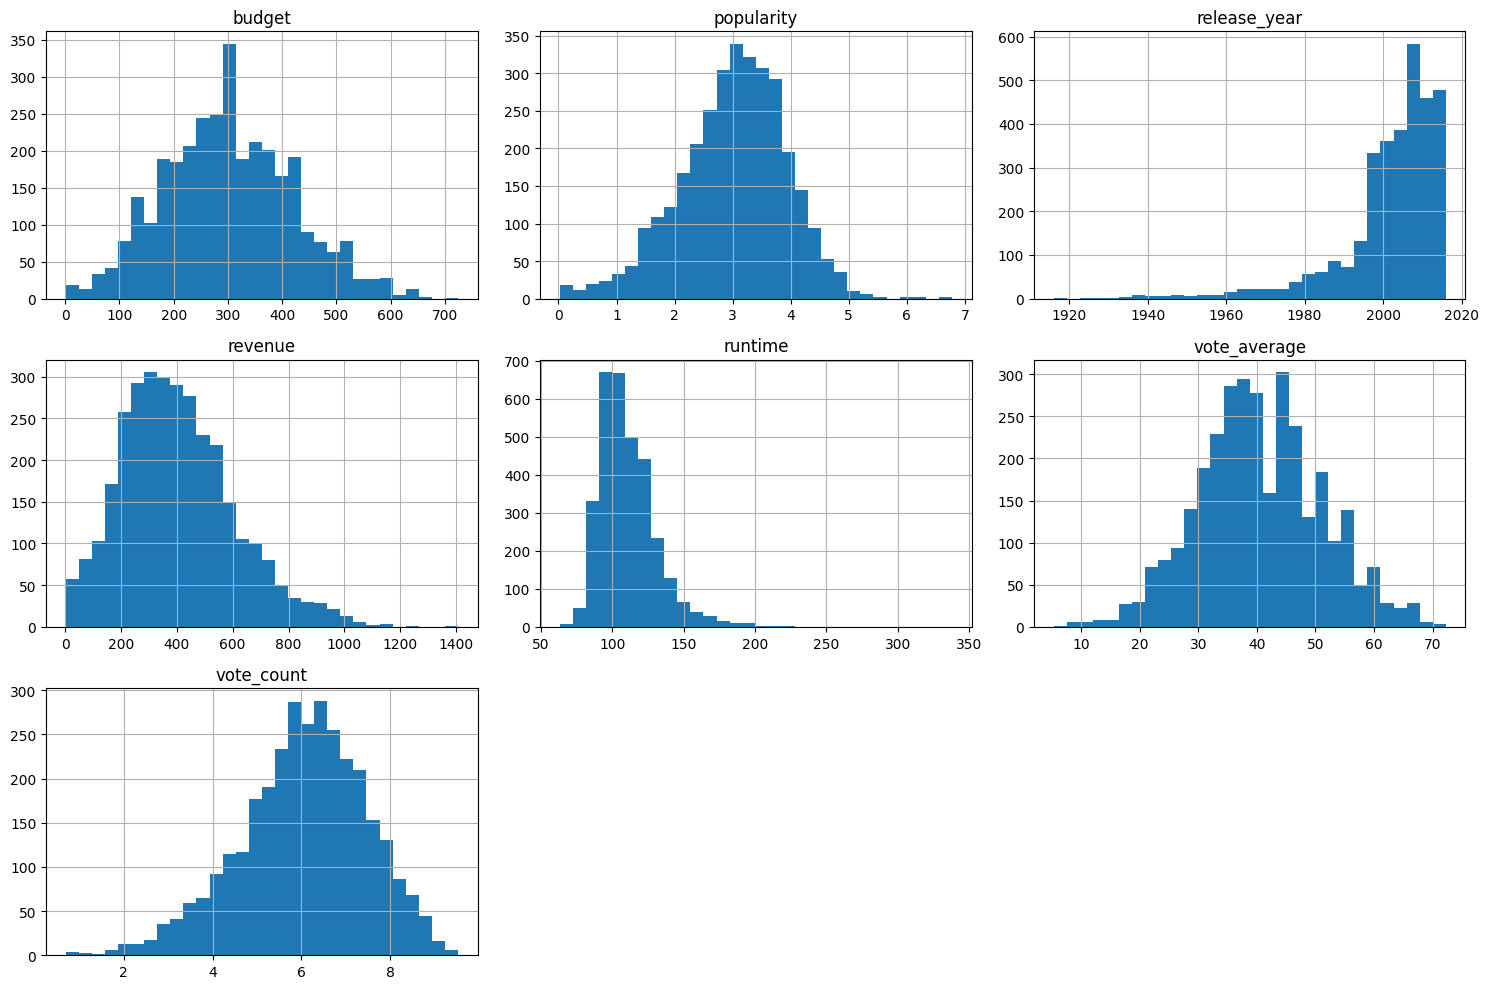

In [17]:
numerical_transformed.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [18]:
### Updates release_year and adds it into the encoded features (via one-hot encoding)

content_based_df['release_year'] = content_based_df['release_year'].astype(int)

# Create bins for every 5 years
bins = list(range(content_based_df['release_year'].min(), content_based_df['release_year'].max() + 20, 20))
labels = [f'{i}-{i+4}' for i in bins[:-1]]

# Create a new column 'release_year_bins' for the binned years
content_based_df['release_year_bins'] = pd.cut(content_based_df['release_year'], bins=bins, labels=labels, include_lowest=True)

# One-hot encode 'release_year_bins'
release_year_encoded = pd.get_dummies(content_based_df['release_year_bins'], prefix='release_year')

# Add the encoded features to the encoded_features DataFrame
encoded_features = pd.concat([encoded_features, release_year_encoded], axis=1)

# Remove release_year from numerical_transformed
numerical_transformed = numerical_transformed.drop(columns=["release_year"])


### Text Feature Engineering
***Variables Handled:***
- keywords
- cast
- director
- overview
- genre

### Combining Features & Providing Results

In [19]:
### Create a combined text feature for cast, crew, and keywords
### Create transformed_df containing all transformed data
    # Creating column text_features (which we will apply transformation function to later)

def create_combined_feature(row):
    # Check if the column values are NaN. If they are, replace with empty string, else use original value.
    keywords = ' '.join(row['keywords']) if isinstance(row['keywords'], list) else ''
    cast = ' '.join(row['cast'][:3]) if isinstance(row['cast'], list) else ''
    director = row['director'] if isinstance(row['director'], str) else 'unknown director'
    overview = row['overview'] if isinstance(row['overview'], str) else ''
    genres = ' '.join(row['genres']) if isinstance(row['genres'], list) else ''
    
    return keywords + ' ' + cast + ' ' + director + ' ' + overview + ' ' + genres

# Initialize transformed_df with just the text features
transformed_df = pd.DataFrame(index=content_based_df.index)
transformed_df['text_features'] = content_based_df.apply(create_combined_feature, axis=1)

In [20]:
### Apply TF-IDF vectorization to the text_features column
     # This converts text-based feature to numerical format
    
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(transformed_df['text_features'])

In [21]:
# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=transformed_df.index)

# Combine the transformed numerical and one-hot encoded features with the TF-IDF matrix
all_transformed_features = pd.concat([transformed_df.drop('text_features', axis=1), tfidf_df], axis=1)
all_transformed_features.dropna(inplace=True)

# Calculate cosine similarity between movies
cosine_sim = cosine_similarity(all_transformed_features, all_transformed_features)

# Function for getting the recommendations given a specific movie and a specific similarity function
def get_recommendations(title, min_rating=7, cosine_sim=cosine_sim):
    idx = content_based_df[content_based_df['title_movies'] == title].index[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[all_transformed_features.index.get_loc(idx)]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the movies that meet the minimum rating requirement
    sim_scores = [score for score in sim_scores if content_based_df.loc[all_transformed_features.index[score[0]], 'vote_average'] >= min_rating]

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]
    sim_scores = [(i[0], i[1]) for i in sim_scores]

    # Get the movie indices
    movie_indices = [all_transformed_features.index[i[0]] for i in sim_scores]

    # Get the top 10 most similar movies with their titles, similarity scores, and ratings
    recommendations = content_based_df.loc[movie_indices, ['title_movies', 'vote_average']]
    recommendations['similarity_score'] = [round(i[1], 4) for i in sim_scores]  # Round to 4 decimal places

    # Reset the index and drop the original index
    recommendations.reset_index(inplace=True, drop=True)
    recommendations.index += 1

    recommendations.columns = ['Movie Title', 'Voting Average', 'Similarity Score']
    return recommendations


In [25]:
print(get_recommendations('Batman Begins'))

                                Movie Title  Voting Average  Similarity Score
1                           The Dark Knight             8.2            0.3608
2                     The Dark Knight Rises             7.6            0.3522
3                                    Batman             7.0            0.3350
4                                  Kick-Ass             7.1            0.1639
5                              The Prestige             8.0            0.1590
6   Batman: The Dark Knight Returns, Part 2             7.9            0.1342
7                           The Incredibles             7.4            0.0979
8                                  Iron Man             7.4            0.0899
9                             The Godfather             8.4            0.0875
10                                 Watchmen             7.0            0.0874


In [30]:
print(get_recommendations('Batman Begins', min_rating=3))

                           Movie Title  Voting Average  Similarity Score
1                      The Dark Knight             8.2            0.3608
2                The Dark Knight Rises             7.6            0.3522
3                               Batman             7.0            0.3350
4                       Batman Returns             6.6            0.2925
5                       Batman & Robin             4.2            0.2598
6   Batman v Superman: Dawn of Justice             5.7            0.2522
7                       Batman Forever             5.2            0.2090
8                         Man of Steel             6.5            0.1750
9                             Defendor             6.5            0.1639
10                            Kick-Ass             7.1            0.1639


In [24]:
print(get_recommendations('Avatar'))

                Movie Title  Voting Average  Similarity Score
1                    Aliens             7.7            0.3087
2                     Alien             7.9            0.2457
3           Treasure Planet             7.2            0.2258
4   Star Trek Into Darkness             7.4            0.2103
5                 The Thing             7.8            0.2002
6                   Gattaca             7.5            0.1938
7     2001: A Space Odyssey             7.9            0.1867
8                   Gravity             7.3            0.1772
9           The Right Stuff             7.3            0.1625
10  Guardians of the Galaxy             7.9            0.1621


In [31]:
print(get_recommendations('Avatar', min_rating=3))

           Movie Title  Voting Average  Similarity Score
1               Aliens             7.7            0.3087
2               Alien³             6.2            0.2756
3            Moonraker             5.9            0.2549
4      Mission to Mars             5.7            0.2540
5                Alien             7.9            0.2457
6      Treasure Planet             7.2            0.2258
7           Spaceballs             6.7            0.2245
8            Lifeforce             6.2            0.2177
9   Planet of the Apes             5.6            0.2139
10             Lockout             5.8            0.2124
